In [1]:
import numpy
import geopandas as gpd
import fiona
import cartopy.crs as ccrs
import numpy as np
import shapely
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
crsPCinit=ccrs.PlateCarree(central_longitude=0).proj4_init

In [3]:
gdir="/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/data/geodata/CanadaEEZ/"

In [4]:
layers = fiona.listlayers(gdir)
layers

['eez']

In [5]:
gpd.show_versions()

ERROR 1: PROJ: proj_create_from_database: /fs/ssm/eccc/cmd/cmds/ext/master/proj_6.3.2-2_rhel-8-amd64-64/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.



SYSTEM INFO
-----------
python     : 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
executable : /home/ords/crd/ccrn/reo000/mamba_files/envs/mpy_geopdB/bin/python
machine    : Linux-4.18.0-240.el8.x86_64-x86_64-with-glibc2.28

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : 3.13.1
GEOS lib   : None
GDAL       : 3.10.2
GDAL data dir: /fs/ssm/eccc/cmd/cmds/ext/master/gdal_3.2.1-1_rhel-8-amd64-64/share/gdal/
PROJ       : 9.5.1
PROJ data dir: /home/ords/crd/ccrn/reo000/mamba_files/envs/mpy_geopdB/lib/python3.13/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 1.0.1
numpy      : 2.2.3
pandas     : 2.2.3
pyproj     : 3.7.1
shapely    : 2.0.7
pyogrio    : 0.10.0
geoalchemy2: None
geopy      : None
matplotlib : 3.10.1
mapclassify: 2.8.1
fiona      : 1.10.1
psycopg    : None
psycopg2   : None
pyarrow    : None


In [6]:
gdf = gpd.read_file(gdir)

In [7]:
gdf

,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,iso_ter1,sovereign1,mrgid_ter2,mrgid_sov2,...,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3,geometry
0,8493,Canadian Exclusive Economic Zone,2169,200NM,2169,Canada,CAN,Canada,NaN,NaN,...,CAN,None,None,124.0,NaN,NaN,124.0,NaN,NaN,"MULTIPOLYGON (((-123.03552 49.00216, -123.0354..."


<Axes: >

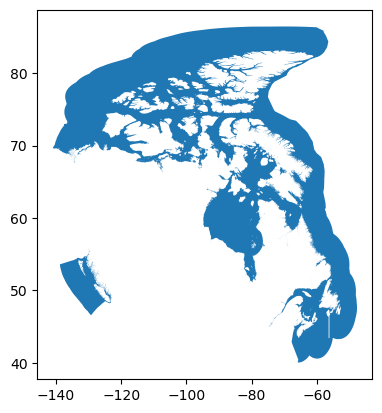

In [8]:
gdf.plot()

In [9]:
gdfPC=gdf.to_crs(crsPCinit).geometry.union_all()#.buffer(.01).simplify(.01)

In [10]:
locmask=np.zeros((181,360))

In [11]:
r=.25
for ii,lon in enumerate(range(-360,0)):
    for jj,lat in enumerate(range(-90,91)):
        #sq=shapely.Point((lon,lat))
        #sq=shapely.Polygon([(lon-.5,lat-.5),(lon+.5,lat-.5),(lon+.5,lat+.5),(lon-.5,lat+.5),(lon-.5,lat-.5)])
        sq=shapely.Polygon([(lon-r,lat-r),(lon+r,lat-r),(lon+r,lat+r),(lon-r,lat+r),(lon-r,lat-r)])
        #if gdfPC.contains(sq):
        if gdfPC.overlaps(sq)|gdfPC.contains(sq):
            locmask[jj,ii]=1

In [12]:
lons=np.arange(0,360)
lats=np.arange(-90,91)

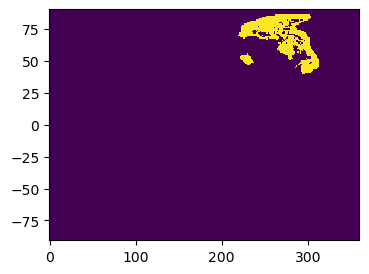

In [13]:
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.pcolormesh(lons,lats,locmask)

In [14]:
locmask=locmask.astype(int)

In [15]:
da=xr.DataArray(locmask, coords={'Y':np.arange(-90,91),'X':np.arange(0,360)}, name='eezmask')

In [16]:
da

<xarray.DataArray 'eezmask' (Y: 181, X: 360)> Size: 521kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(181, 360))
Coordinates:
  * Y        (Y) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * X        (X) int64 3kB 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

In [17]:
da.to_netcdf('eezmask.nc',mode='w')